tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3, 2, 2, 1, 1])
800 500 800 500 500 500


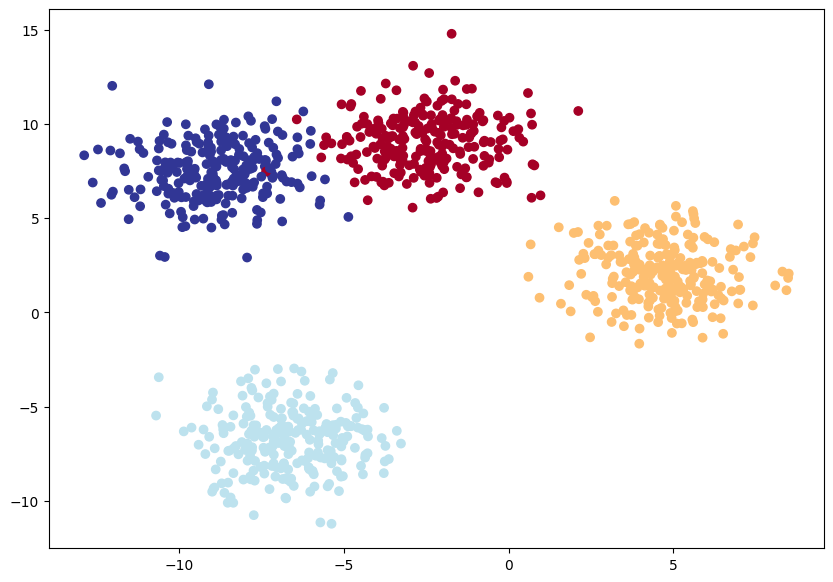

In [108]:
# Multiclass classification
# loosely following https://www.learnpytorch.io/02_pytorch_classification/
# with help from:
# https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html#sphx-glr-beginner-blitz-neural-networks-tutorial-py
# and Andrej Karpathy's youtube channel. 

# the zeroth model is a simple full batch training, called: multi_class_model 
# the model multi_class_model_mb, which is the second model trained is with 
# minibatches assigned in a for loop (i.e. without the DataLoader assistence)

# compared to the binary training examples that I implemented this has better
# initialization of the output layer, to give more even probability predictions
# on initialization. 

# Import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X, Y = make_blobs(n_samples=1000,
                  n_features=NUM_FEATURES, # X features
                  centers=NUM_CLASSES, # y labels 
                  cluster_std=1.5, 
                  random_state=RANDOM_SEED)

# 2. Turn data into tensors
X= torch.from_numpy(X).type(torch.float)
Y = torch.from_numpy(Y).type(torch.LongTensor)
print(X[:5], Y[:5])

# 3. Split into train and test sets
X_train, X_test, Y_train, Y_test \
                                   = train_test_split(X,
                                                      Y,
                                                      test_size=0.2,
                                                      random_state=RANDOM_SEED)
                                   
# split the test set into  0.5 test and 0.5 validation; i.e. 10% of 
# original data
X_val, X_test, Y_val, Y_test = train_test_split(X, 
                                                Y, 
                                                test_size=0.5, 
                                                random_state=42) 

print(len(X_train), len(X_test), len(Y_train), len(Y_test), \
                                                len(Y_val), len(X_val))                                   


# 4. Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=plt.cm.RdYlBu);

In [109]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [110]:
torch.manual_seed(42) # for reproducability

In [111]:
# Define the network
import torch.nn as nn
import torch.nn.functional as F
class Multi_class_classifier(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    """
    Initializes all required hyperparameters for a multi-class 
    classification model.

    Args:
      input_features (int): Number of input features to the model.
      out_features (int): Number of output features of the model
        (how many classes there are).
      hidden_units (int): Number of hidden units between layers, 
      default 8.
    """
    super().__init__()
    self.L0 = nn.Linear(input_features, hidden_units)
    self.L1 = nn.Linear(hidden_units, hidden_units)
    self.L2 = nn.Linear(hidden_units, output_features)
    nn.init.constant_(self.L0.bias, 0.0)
    nn.init.kaiming_normal_(self.L0.weight, \
                           mode='fan_in', \
                           nonlinearity='relu')
    nn.init.constant_(self.L1.bias, 0.0)
    nn.init.kaiming_normal_(self.L1.weight, \
                             mode='fan_in', \
                             nonlinearity='relu')
    # to make initial logits come out close to equal (i.e. represent our high 
    # uncertainty) we're aiming for a distribution of equal probability
    # for each class. If the weights for this layer all start close to zero
    # then each output node should have a value close to zero and the
    # result should be close to equal probability for each outcome. 
    # This reduces the initial loss from around 1.6 with no special init. 
    # to 1.38 (ln(4) = 1.386) on the tests here, which is as low as one 
    # might expect without training. 
    with torch.no_grad():
      self.L2.weight.data = self.L2.weight.data * 0.01
    nn.init.constant_(self.L2.bias, 0.0)

  def forward(self, X):
    X = F.relu(self.L0(X))
    X = F.relu(self.L1(X))
    X = self.L2(X)
    return X
  





In [112]:
multi_class_model = Multi_class_classifier(NUM_FEATURES, NUM_CLASSES, hidden_units=8).to(device)
multi_class_model


Multi_class_classifier(
  (L0): Linear(in_features=2, out_features=8, bias=True)
  (L1): Linear(in_features=8, out_features=8, bias=True)
  (L2): Linear(in_features=8, out_features=4, bias=True)
)

In [113]:
X_train[:5]

tensor([[ 5.0405,  3.3076],
        [-2.6249,  9.5260],
        [-8.5240, -9.0402],
        [-6.0262, -4.4375],
        [-3.3397,  7.2175]])

In [114]:
# Perform a single forward pass on the data 
multi_class_model(X_train.to(device))[:5]


tensor([[-0.0141, -0.0022, -0.0133, -0.0165],
        [ 0.0087,  0.0008, -0.0035, -0.0110],
        [-0.0076, -0.0517, -0.0456, -0.0245],
        [-0.0047, -0.0311, -0.0275, -0.0140],
        [ 0.0085, -0.0029, -0.0025, -0.0059]], grad_fn=<SliceBackward0>)

In [115]:
# check initial loss

In [116]:
# check for dead ReLUs

In [117]:
# check can ovefit on one example to confirm the network works. 

In [118]:
# Make prediction logits with model
Y_logits = multi_class_model(X_test.to(device))
# Assign class as one with highest probability from softmax
Y_pred_class = torch.softmax(Y_logits, dim=1).argmax(dim=1)
# save probabilities 
Y_pred_probs = torch.softmax(Y_logits, dim=1) 
print(Y_logits[:5])
print(Y_pred_probs[:5])


tensor([[-0.0135, -0.0044, -0.0141, -0.0194],
        [ 0.0117, -0.0202, -0.0096, -0.0020],
        [-0.0058, -0.0401, -0.0353, -0.0190],
        [-0.0072,  0.0008, -0.0070, -0.0084],
        [ 0.0036,  0.0026, -0.0056, -0.0170]], grad_fn=<SliceBackward0>)
tensor([[0.2498, 0.2521, 0.2497, 0.2484],
        [0.2542, 0.2462, 0.2489, 0.2508],
        [0.2548, 0.2462, 0.2474, 0.2515],
        [0.2496, 0.2516, 0.2496, 0.2493],
        [0.2519, 0.2517, 0.2496, 0.2468]], grad_fn=<SliceBackward0>)


In [119]:
def calculate_accuracy(Y_train, Y_pred_class): 
  true_positives=(Y_pred_class==Y_train).sum()
  number_of_predictions = len(Y_pred_class)
  return 100 * true_positives/number_of_predictions

In [120]:
learning_rate = 0.05
# loss function #optimizer
calculate_loss = nn.CrossEntropyLoss() # includes softmax in cost function
optimizer = torch.optim.Adam(params=multi_class_model.parameters(), 
                            lr=learning_rate)
epochs = 2000

# lists to store progress
train_loss_values = []
validation_loss_values = []
epoch_count = []

for epoch in range(epochs):
  # 1. Forward pass
  Y_logits = multi_class_model(X_train)
  Y_pred_class = torch.softmax(Y_logits, dim=1).argmax(dim=1)
  Y_pred_probs = torch.softmax(Y_logits, dim=1) 

  # 2. Calculate loss and accuracy prior to backprop.
  loss = calculate_loss(Y_logits, Y_train) 
  acc = calculate_accuracy(Y_train, Y_pred_class)
  train_loss_values.append(loss.detach().item())
  epoch_count.append(epoch)

  # 4. Validation data prior to backprop. 
  multi_class_model.eval()
  with torch.inference_mode():
    # 1. Forward pass
    validation_logits = multi_class_model(X_val)
    validation_pred = torch.softmax(validation_logits, dim=1).argmax(dim=1)
    # 2. Calculate test loss and accuracy
    validation_loss = calculate_loss(validation_logits, Y_val)
    validation_acc = calculate_accuracy(Y_val,
                                 validation_pred)
    validation_loss_values.append(validation_loss.detach().item())

  # 3. back propagation
  optimizer.zero_grad()   # zero grads
  loss.backward()
  optimizer.step()



  # Print out what's happening
  if epoch % 50 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% |\
      Validation Loss: {validation_loss:.5f}, \
      Validation Acc: {validation_acc:.2f}%")


# 5. Final loss
multi_class_model.eval()
with torch.inference_mode():
  # 1. Forward pass validation
  validation_logits = multi_class_model(X_val)
  validation_pred = torch.softmax(validation_logits, dim=1).argmax(dim=1)
  # 2. Calculate test loss and accuracy
  validation_loss = calculate_loss(validation_logits, Y_val)
  validation_acc = calculate_accuracy(Y_val,
                                validation_pred)
  validation_loss_values.append(validation_loss.detach().item())
  # 1. Forward pass with training data
  Y_logits = multi_class_model(X_train)
  Y_pred_class = torch.softmax(Y_logits, dim=1).argmax(dim=1)
  Y_pred_probs = torch.softmax(Y_logits, dim=1)
  loss = calculate_loss(Y_logits, Y_train) 
  #print("Y_train, Y_pred_class", Y_train[0:10], Y_pred_class[0:10])
  acc = calculate_accuracy(Y_train, Y_pred_class)
  #print("acc", acc)
  train_loss_values.append(loss.detach().item())
  epoch_count.append(epoch)

print(f"Final model losses/accuracies. | Loss: {loss:.5f}, Acc: {acc:.2f}% |\
Validation Loss: {validation_loss:.5f}, \
Validation Acc: {validation_acc:.2f}%")

Epoch: 0 | Loss: 1.38344, Acc: 50.00% |      Validation Loss: 1.38344,       Validation Acc: 50.80%
Epoch: 50 | Loss: 0.02120, Acc: 99.38% |      Validation Loss: 0.02411,       Validation Acc: 99.40%
Epoch: 100 | Loss: 0.01732, Acc: 99.50% |      Validation Loss: 0.01908,       Validation Acc: 99.60%
Epoch: 150 | Loss: 0.01616, Acc: 99.38% |      Validation Loss: 0.01838,       Validation Acc: 99.40%
Epoch: 200 | Loss: 0.01534, Acc: 99.38% |      Validation Loss: 0.01770,       Validation Acc: 99.40%
Epoch: 250 | Loss: 0.01523, Acc: 99.38% |      Validation Loss: 0.01679,       Validation Acc: 99.40%
Epoch: 300 | Loss: 0.01430, Acc: 99.38% |      Validation Loss: 0.01701,       Validation Acc: 99.40%
Epoch: 350 | Loss: 0.01406, Acc: 99.50% |      Validation Loss: 0.01666,       Validation Acc: 99.40%
Epoch: 400 | Loss: 0.05546, Acc: 98.88% |      Validation Loss: 0.06065,       Validation Acc: 99.00%
Epoch: 450 | Loss: 0.01543, Acc: 99.38% |      Validation Loss: 0.01881,       Valida

In [121]:
len(epoch_count), len(validation_loss_values), len(train_loss_values)

(2001, 2001, 2001)

In [122]:
train_loss_values[0:1]

[1.383439064025879]

In [123]:
epoch_count[:1], len(epoch_count)

([0], 2001)

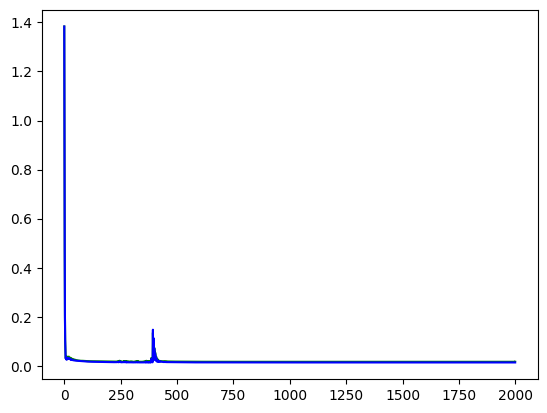

In [139]:
import matplotlib.pyplot as plt
plt.plot(epoch_count, validation_loss_values, c="g")
plt.plot(epoch_count, train_loss_values, c="b")

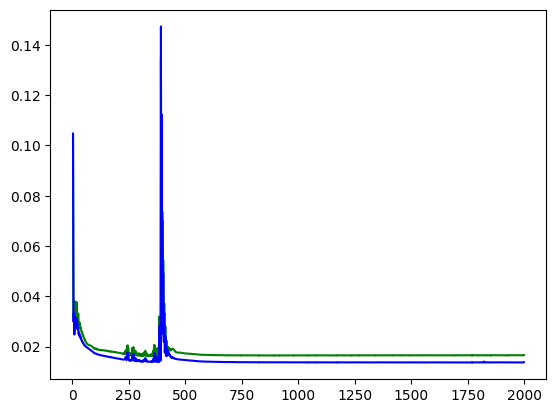

In [140]:
import matplotlib.pyplot as plt
plt.plot(epoch_count[4:], validation_loss_values[4:], c="g")
plt.plot(epoch_count[4:], train_loss_values[4:], c="b")

In [125]:
# show decision boundaries
# make a grid of input data to feed to the network.
# the output will form the basis of the contour plot.
# our  data has range approx. -15 to +15 along the axes
import numpy as np
#xx, yy = np.mgrid[-1.0:1.0:.01, -1.0:1.0:.01]
# Generate a grid of points over the input space
# x, y are two axes, not dependent and label data
x_min, x_max = -16, 16
y_min, y_max = -16, 16
step = 0.25
# matrices for coordinates on the grid, taking x from xx, y from yy.
xx, yy = \
       np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))
grid = np.c_[xx.ravel(), yy.ravel()] # pair x and y for coordinate

In [126]:
len(xx), len(yy), len(grid), xx[0:2]

(128,
 128,
 16384,
 array([[-16.  , -15.75, -15.5 , -15.25, -15.  , -14.75, -14.5 , -14.25,
         -14.  , -13.75, -13.5 , -13.25, -13.  , -12.75, -12.5 , -12.25,
         -12.  , -11.75, -11.5 , -11.25, -11.  , -10.75, -10.5 , -10.25,
         -10.  ,  -9.75,  -9.5 ,  -9.25,  -9.  ,  -8.75,  -8.5 ,  -8.25,
          -8.  ,  -7.75,  -7.5 ,  -7.25,  -7.  ,  -6.75,  -6.5 ,  -6.25,
          -6.  ,  -5.75,  -5.5 ,  -5.25,  -5.  ,  -4.75,  -4.5 ,  -4.25,
          -4.  ,  -3.75,  -3.5 ,  -3.25,  -3.  ,  -2.75,  -2.5 ,  -2.25,
          -2.  ,  -1.75,  -1.5 ,  -1.25,  -1.  ,  -0.75,  -0.5 ,  -0.25,
           0.  ,   0.25,   0.5 ,   0.75,   1.  ,   1.25,   1.5 ,   1.75,
           2.  ,   2.25,   2.5 ,   2.75,   3.  ,   3.25,   3.5 ,   3.75,
           4.  ,   4.25,   4.5 ,   4.75,   5.  ,   5.25,   5.5 ,   5.75,
           6.  ,   6.25,   6.5 ,   6.75,   7.  ,   7.25,   7.5 ,   7.75,
           8.  ,   8.25,   8.5 ,   8.75,   9.  ,   9.25,   9.5 ,   9.75,
          10.  ,  10.25,  10.5 

In [127]:
  multi_class_model.eval()
  with torch.inference_mode():
    # 1. Forward pass
    #X_test = torch.FloatTensor(grid).to(device)
    X_for_contours = torch.tensor(grid).type('torch.FloatTensor').to(device)
    logits = multi_class_model(X_for_contours)

In [128]:
logits[0:2]

tensor([[-134.2488,   34.2773,  125.1626,  -32.9062],
        [-131.1999,   32.7683,  122.6911,  -32.5428]])

In [129]:
probs = torch.softmax(logits, dim=1).to(device).numpy()
predictions = torch.softmax(logits, dim=1).argmax(dim=1)
len(probs), len(logits), len(xx), xx.shape

(16384, 16384, 128, (128, 128))

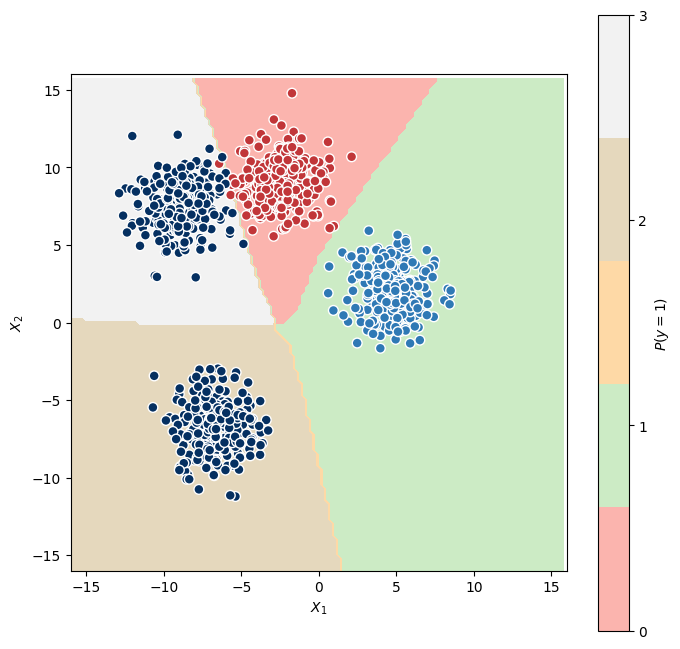

tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984]]) tensor([3, 2, 2, 1])


In [130]:

Z = predictions.reshape(xx.shape)

'''
# Plot the decision boundary
plt.contourf(xx, yy, Z, cmap=plt.cm.RdBu, alpha=0.8)
plt.colorbar()
plt.show()
'''


f, ax = plt.subplots(figsize=(8, 8))
contour = ax.contourf(xx, yy, Z, 4, cmap="Pastel1",
                      vmin=0, vmax=3)

ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, 1, 2, 3])

ax.scatter(X[:,0], X[:, 1], c=Y[:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(aspect="equal",\
       xlim=(-16, 16), ylim=(-16, 16),\
       xlabel="$X_1$", ylabel="$X_2$")
plt.show()

# double check which data labelled 1 and which labelled 0 
print(X[:4,:], Y[:4])

######################  Mini batch model - hand coded ############################


In [131]:
torch.manual_seed(42)

In [148]:
int(800 / 64)


12

In [167]:
# Second model training - practicing using mini-batches in pytorch. 
multi_class_model_mb = \
  Multi_class_classifier(NUM_FEATURES, NUM_CLASSES, hidden_units=8).to(device)
learning_rate = 0.05
# loss function #optimizer
calculate_loss = nn.CrossEntropyLoss() # includes softmax in cost function
optimizer = torch.optim.Adam(params=multi_class_model_mb.parameters(), 
                            lr=learning_rate)
epochs = 200
batch_size = 64

# lists to store progress
train_loss_values_full_set = []
train_loss_values_mb = []
validation_loss_values = []
epoch_count = []
batch_count = []
batch_iter_count = 0

iterations_per_epoch = int(len(X_train)/batch_size)
# make sure you get the remainder of the data. 
if len(X_train) % batch_size != 0: iterations_per_epoch += 1
print("iterations_per_epoch, len(X_train), batch_size", \
      iterations_per_epoch, str(len(X_train)), str(batch_size))
for epoch in range(epochs):
  for i in range(iterations_per_epoch):
    # take a batch
    start = i * batch_size
    X_batch = X_train[start:start+batch_size]
    Y_batch = Y_train[start:start+batch_size]
    #print("i, start+batch_size, len(X_train)", \
    #      str(i), str(start+batch_size), len(X_train))
    #print("Y_batch", Y_batch)
    # 1. Forward pass
    Y_logits = multi_class_model_mb(X_batch)
    Y_pred_class = torch.softmax(Y_logits, dim=1).argmax(dim=1)
    Y_pred_probs = torch.softmax(Y_logits, dim=1) 

    # 2. Calculate loss and accuracy
    loss = calculate_loss(Y_logits, Y_batch) 
    #print("Y_train, Y_pred_class", Y_train[0:10], Y_pred_class[0:10])
    acc = calculate_accuracy(Y_batch, Y_pred_class)
    #print("acc", acc)
    train_loss_values_mb.append(loss.detach().item())
    batch_count.append(batch_iter_count)
    batch_iter_count += 1

    
    # 3. back propagation
    optimizer.zero_grad()   # zero grads
    loss.backward()
    optimizer.step()

  # validate every epoch and loss for full X_train every epoch. 
  # 3. Validation for this epoch. 
  multi_class_model_mb.eval()
  with torch.inference_mode():
    # 1. Forward pass with training data
    Y_logits = multi_class_model_mb(X_train)
    Y_pred_class = torch.softmax(Y_logits, dim=1).argmax(dim=1)
    Y_pred_probs = torch.softmax(Y_logits, dim=1)
    loss = calculate_loss(Y_logits, Y_train) 
    #print("Y_train, Y_pred_class", Y_train[0:10], Y_pred_class[0:10])
    acc = calculate_accuracy(Y_train, Y_pred_class)
    #print("acc", acc)
    train_loss_values_full_set.append(loss.detach().item())
    epoch_count.append(epoch)
    
    # 1. Forward pass _validation
    validation_logits = multi_class_model_mb(X_val)
    validation_pred = torch.softmax(validation_logits, dim=1).argmax(dim=1)
    # 2. Calculate test loss and accuracy
    validation_loss = calculate_loss(validation_logits, Y_val)
    validation_acc = calculate_accuracy(Y_val,
                                validation_pred)
    validation_loss_values.append(validation_loss.detach().item())

  # Print out what's happening prior to back prop.
  if epoch % 50 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% |\
      Validation Loss: {validation_loss:.5f}, \
      Validation Acc: {validation_acc:.2f}%")

# 5. Final loss
multi_class_model_mb.eval()
with torch.inference_mode():
  # 1. Forward pass validation
  validation_logits = multi_class_model_mb(X_val)
  validation_pred = torch.softmax(validation_logits, dim=1).argmax(dim=1)
  # 2. Calculate test loss and accuracy
  validation_loss = calculate_loss(validation_logits, Y_val)
  validation_acc = calculate_accuracy(Y_val,
                                validation_pred)
  #validation_loss_values_mb.append(validation_loss.detach().item())
  # 1. Forward pass with training data
  Y_logits = multi_class_model_mb(X_train)
  Y_pred_class = torch.softmax(Y_logits, dim=1).argmax(dim=1)
  Y_pred_probs = torch.softmax(Y_logits, dim=1)
  loss = calculate_loss(Y_logits, Y_train) 
  #print("Y_train, Y_pred_class", Y_train[0:10], Y_pred_class[0:10])
  acc = calculate_accuracy(Y_train, Y_pred_class)
  #print("acc", acc)
  #train_loss_values_mb.append(loss.detach().item())
  #epoch_count_mb.append(epoch)

print(f"Final model losses/accuracies. | Loss: {loss:.5f}, Acc: {acc:.2f}% |\
Validation Loss: {validation_loss:.5f}, \
Validation Acc: {validation_acc:.2f}%")

iterations_per_epoch, len(X_train), batch_size 13 800 64
Epoch: 0 | Loss: 0.02988, Acc: 99.12% |      Validation Loss: 0.03378,       Validation Acc: 99.40%
Epoch: 50 | Loss: 0.01519, Acc: 99.38% |      Validation Loss: 0.01731,       Validation Acc: 99.40%
Epoch: 100 | Loss: 0.01463, Acc: 99.38% |      Validation Loss: 0.01666,       Validation Acc: 99.40%
Epoch: 150 | Loss: 0.01416, Acc: 99.38% |      Validation Loss: 0.01645,       Validation Acc: 99.40%
Final model losses/accuracies. | Loss: 0.01352, Acc: 99.50% |Validation Loss: 0.01593, Validation Acc: 99.40%


In [157]:
multi_class_model_mb.L0.weight.data


tensor([[-0.2395, -0.8572],
        [ 1.2565,  0.6897],
        [ 2.3407, -0.5233],
        [-0.4995,  0.2214],
        [ 1.7791, -0.4442],
        [ 2.9374, -0.5804],
        [-1.8769, -0.5308],
        [ 0.4623,  0.3265]])

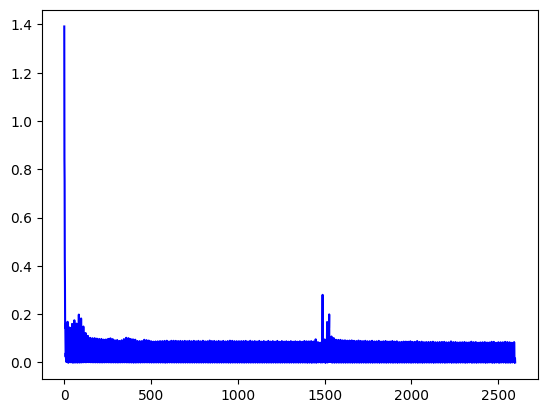

In [168]:

plt.plot(batch_count, train_loss_values_mb, c="b")
plt.show()

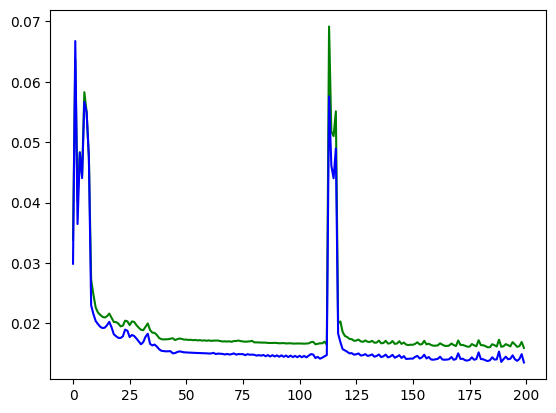

In [169]:
plt.plot(epoch_count, validation_loss_values, c="g")
plt.plot(epoch_count, train_loss_values_full_set, c="b")
plt.show()

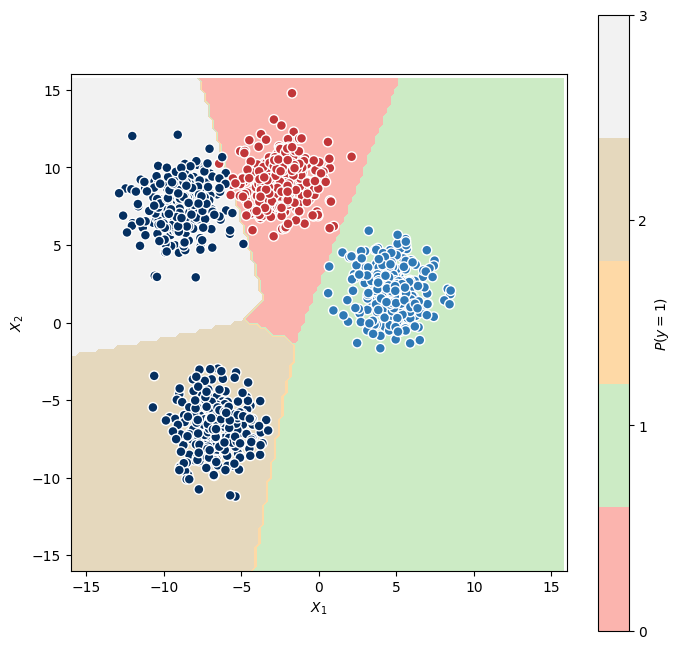

tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984]]) tensor([3, 2, 2, 1])


In [170]:
  multi_class_model_mb.eval()
  with torch.inference_mode():
    # 1. Forward pass
    #X_test = torch.FloatTensor(grid).to(device)
    X_for_contours = torch.tensor(grid).type('torch.FloatTensor').to(device)
    logits = multi_class_model_mb(X_for_contours)

  probs = torch.softmax(logits, dim=1).to(device).numpy()
  predictions = torch.softmax(logits, dim=1).argmax(dim=1)
  #len(probs), len(logits), len(xx), xx.shape

  Z = predictions.reshape(xx.shape)

'''
# Plot the decision boundary
plt.contourf(xx, yy, Z, cmap=plt.cm.RdBu, alpha=0.8)
plt.colorbar()
plt.show()
'''


f, ax = plt.subplots(figsize=(8, 8))
contour = ax.contourf(xx, yy, Z, 4, cmap="Pastel1",
                      vmin=0, vmax=3)

ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, 1, 2, 3])

ax.scatter(X[:,0], X[:, 1], c=Y[:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(aspect="equal",\
       xlim=(-16, 16), ylim=(-16, 16),\
       xlabel="$X_1$", ylabel="$X_2$")
plt.show()

# double check which data labelled 1 and which labelled 0 
print(X[:4,:], Y[:4])